# This notebook 

In [1]:
from wfield_utils import *
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 1. Reading the avg movies

The cell below reads the avg movie files, assuming they are all in seperate run directories(result of running different protocol files in batch mode in stimpy).

The last part of the prot file name seperated with an underscore(`_`) will be the key in the final` avg_mov_dict` dictionary,e.g. the run __run00_131844_02_checkerboard_lowSF_calcium__ will have the key `calcium`. If you want to change this, rename the protocol files accordingly.

__IMPORTANT : `read_avgs` method automatically flips the movies in the medial-lateral axis__

In [2]:
avg_mov_dict = read_avgs(r'J:\analysis\221220_VO042__1P_VO',codebase='ben')

calcium: 100%|██████████| 2/2 [00:13<00:00,  6.50s/it]       


This process assumes that there are no frames corresponding to pre- or post-blank periods. If that is not the case, you can index the 0th dimension accordingly to get rid of those frames.

For example, if you know that the first 10 frames correspond to pre-blank period, you can do:

```avg_movie = avg_movie[10:,:,:]```

__Don't run the cell below if you don't have any blank frames__

In [3]:
avg_mov_dict.keys()

dict_keys(['checkercalcium_avg_01', 'checkercalcium_avg_02', 'calcium_avg_01', 'calcium_avg_02'])

In [5]:
for k,v in avg_mov_dict.items():
    avg_mov_dict[k] = v[17:,:,:]

## 2. Accounting for delay

To account for delay, we flip one of the opposite directions and get a pixel-by-pixel average for each frame.

Below we use the dictionary `azi_alt_dict` to keep the 'delay accounted' avg movies and other related data we get from processing those movies.

__This part uses explicit keys to acces the movies in the `avg_mov_dict` dictionary. So be careful you have the correct keys for opposing directions.__

In [6]:
azi_alt_dict = {'azimuth' : {'avg_mov' : np.mean([avg_mov_dict['M2T'],avg_mov_dict['T2M'][::-1,:,:]],axis=0)},
                'altitude' : {'avg_mov' : np.mean([avg_mov_dict['B2T'],avg_mov_dict['T2B'][::-1,:,:]],axis=0)}}

In [4]:
azi_alt_dict = {'azimuth' : {'avg_mov' : avg_mov_dict['calcium_avg_01']},
                'altitude' : {'avg_mov' : avg_mov_dict['calcium_avg_02']}}

## 3. Get the phase and mag for each avg movie 

Again. since we are working with averages, we will take the first component of the frequency domain reulsts.

In [5]:
component = 1

for k,v in tqdm(azi_alt_dict.items(),desc='Doing FFT'):
    movief = fft(v['avg_mov'], axis = 0)
    azi_alt_dict[k]['moveif'] = movief
    azi_alt_dict[k]['phase'] = np.angle(movief[component]) % (2*np.pi)
    azi_alt_dict[k]['mag'] = np.abs(movief[component])

Doing FFT: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


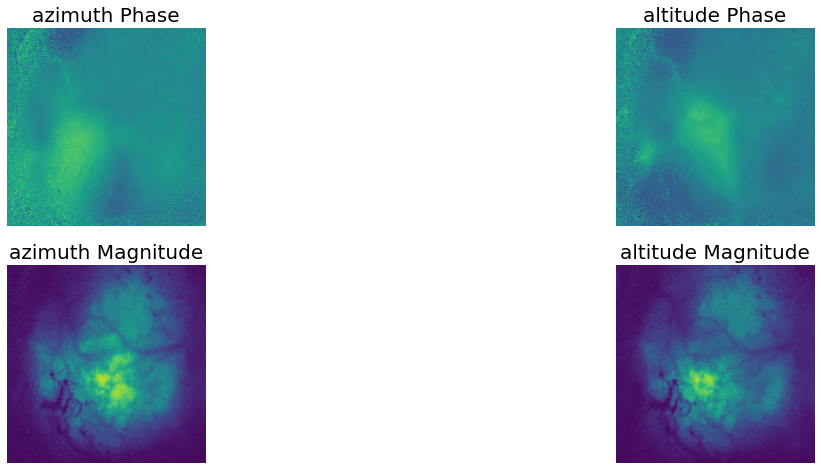

In [6]:
fig = plt.figure(figsize=(20,8))

clim_low = 30
clim_high = 60
for i,k in enumerate(azi_alt_dict.keys()):
#     cr = [int(azi_alt_dict[k]['phase'].shape[0]*clim_low/100),int(phase_dict['M2T'].shape[1]*clim_high/100)]
    ax_p = fig.add_subplot(2,2,1+i)
    ax_p.imshow(azi_alt_dict[k]['phase'])
#     ax_p.set_clim(np.percentile(p_img[cr[0]:cr[1],cr[0]:cr[1]],5),np.percentile(p_img[cr[0]:cr[1],cr[0]:cr[1]],95))
    ax_p.set_axis_off()
    ax_p.set_title(f'{k} Phase',fontsize=20)
    
    ax_m = fig.add_subplot(2,2,3+i)
    ax_m.imshow(azi_alt_dict[k]['mag'])
#     ax_m.set_clim(np.percentile(m_img[cr[0]:cr[1],cr[0]:cr[1]],5),np.percentile(m_img[cr[0]:cr[1],cr[0]:cr[1]],95))
    ax_m.set_axis_off()
    ax_m.set_title(f'{k} Magnitude',fontsize=20)


## 4. Get the visual sign maps

We combine the phasemaps of two directions, get their gradients and get the arctangent.

The exact values for the Gaussian filters used are a bit arbitrary, so we loop through a range of values to have an idea of which values to use.

This cell takes a couple of minutes to finish.

100%|██████████| 5/5 [00:56<00:00, 11.32s/it]


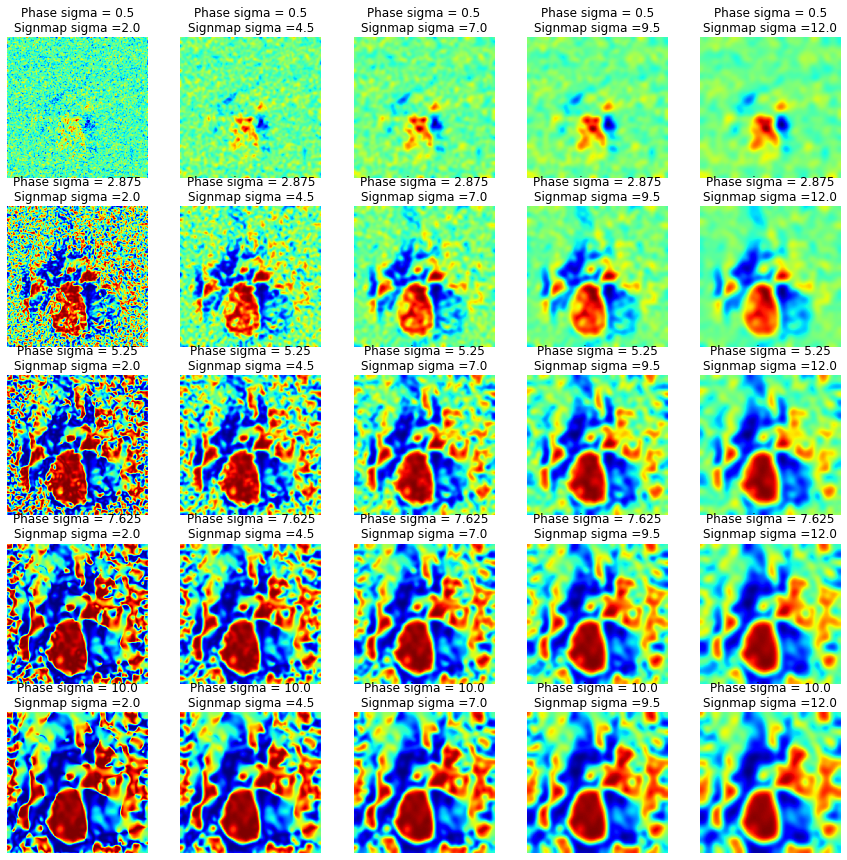

In [7]:
map_filter = np.linspace(0.5,10,5)
signmap_filter = np.linspace(2,12,5)
f,axs = plt.subplots(5,5,figsize=(15,15))

for i in tqdm(range(len(map_filter))): 
    
    altphasefilt=gaussian_filter(azi_alt_dict['altitude']['phase'],map_filter[i])
    aziphasefilt=gaussian_filter(azi_alt_dict['azimuth']['phase'],map_filter[i])
    
    for j in range(len(signmap_filter)):
        
        areamap = visual_sign_map(aziphasefilt,altphasefilt)
        areamapfilt = gaussian_filter(areamap,signmap_filter[j])
        
        axs[i][j].imshow(areamapfilt,cmap='jet', interpolation='nearest')
        axs[i][j].set_title('Phase sigma = {0}\nSignmap sigma ={1}'.format(map_filter[i],signmap_filter[j]))
        axs[i][j].set_axis_off()

Below you can enter the desired filter values to have the sign map. You can also change the variables that are listed at the topp of the cell to see how the thresholding and 'borderizing' changes.

For example, thresholding is done to have more rigid border lines, you can play with the `thresh` variable to see which value works the best.

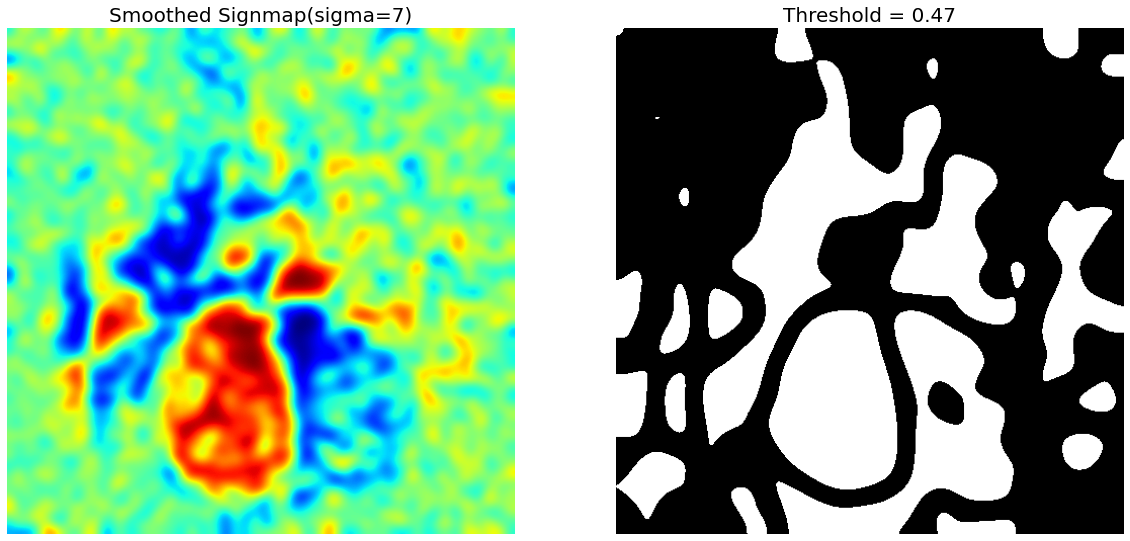

In [15]:
## CHANGE THESE VARIABLES ##
phasemap_sigma = 2.9 
signmap_sigma = 7
thresh = 0.47

# Gaussian smooth the phase maps
altphase_filt=gaussian_filter(azi_alt_dict['altitude']['phase'],phasemap_sigma)
aziphase_filt=gaussian_filter(azi_alt_dict['azimuth']['phase'],phasemap_sigma)

# Get the visual sign map and also do gaussian smoothing
signmap = visual_sign_map(aziphase_filt,altphase_filt)
signmap_filt = gaussian_filter(signmap,signmap_sigma)

# Do the thresholding
patchmap = np.zeros_like(areamapfilt)
patchmap[areamapfilt >= thresh] = 1
patchmap[areamapfilt <= -1*thresh] = 1
patchmap[(areamapfilt > -1*thresh) & (areamapfilt < thresh)] = 0

# Plotting signmap and thresholded patches
fig = plt.figure(figsize=(20,10))

# Sign map
ax1 = fig.add_subplot(121)
ax1.imshow(signmap_filt,cmap='jet')
ax1.set_title(f'Smoothed Signmap(sigma={signmap_sigma})',fontsize=20)
ax1.set_axis_off()

# Thresholded
ax2 = fig.add_subplot(122)
map_thresh = ax2.imshow(patchmap,cmap='gray')
ax2.set_title(f'Threshold = {thresh}',fontsize=20)
ax2.set_axis_off()

Finalizing: 100%|██████████| 1814/1814 [00:14<00:00, 128.47it/s]


Text(0.5, 1.0, 'Borders')

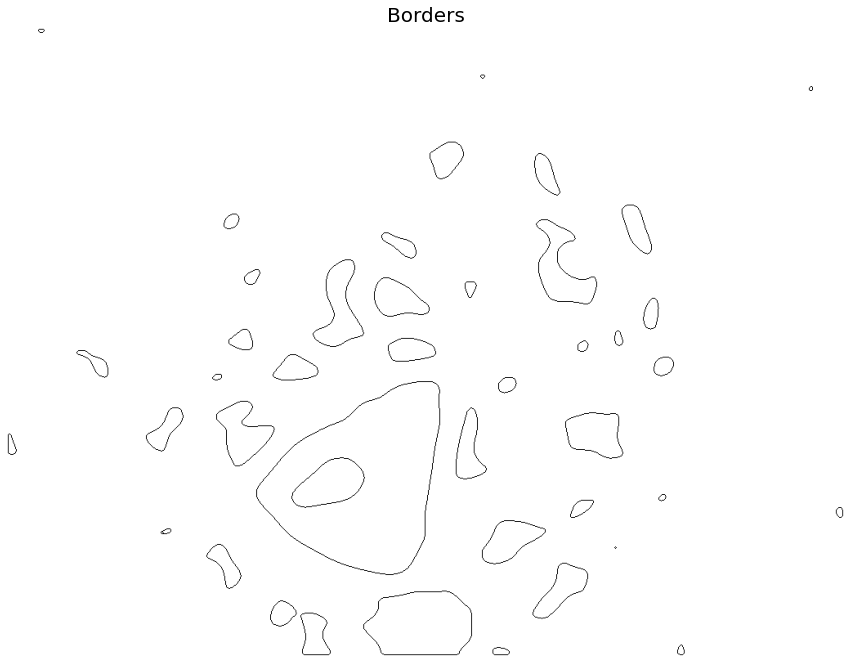

In [9]:
## CHANGE THESE VARIABLES ##
erosion_iter = 3
closing_iter = 3
dilation_iter = 3

# Some morphological filters 
# Opening, closing and dilating the patches to join some patches and to get rid of very small patches
patchmap1 = ni.binary_erosion(np.abs(patchmap),iterations=erosion_iter).astype(int)
patches,patch_num = ni.label(patchmap1)

patchmap2 = np.zeros_like(patchmap1).astype(int)
for i in tqdm(range(patch_num),desc='Closing patches'):
    currPatch = np.zeros_like(patches).astype(int)
    currPatch[patches == i + 1] = 1
    currPatch = ni.binary_closing(currPatch, iterations=closing_iter).astype(int)
    patchmap2 += currPatch

total_area = ni.binary_dilation(patchmap2, iterations=dilation_iter).astype(int)
patchBorder = total_area - patchmap2

patchBorder = skeletonize(patchBorder)
newPatches = np.multiply(-1 * (patchBorder - 1), total_area)
labeledPatches, patchNum = ni.label(newPatches)

newPatches2 = np.zeros_like(newPatches).astype(int)
for i in tqdm(range(1, patchNum + 1),desc='Finalizing'):
    currPatch = np.zeros_like(labeledPatches).astype(int)
    currPatch[labeledPatches == i] = 1
    currPatch[labeledPatches != i] = 0

    if (np.sum(np.multiply(currPatch, patchmap2)[:]) > 0):
        newPatches2[currPatch == 1] = 1
        
# Plotting
fig = plt.figure(figsize=(15,15))

# Borders
ax3 = fig.add_subplot(111)
ax3.imshow(patchBorder,cmap='gray_r')
ax3.set_axis_off()
ax3.set_title('Borders',fontsize=20)

### Save the figure in the figures folder in this directory, don't forget to change the `save_name`.

In [10]:
save_name = '201010_KC300_1P_borders'
fig.savefig(f'figures/{save_name}.pdf')